## Blog As You Go GAN  

In [28]:
#imports
from matplotlib import pyplot
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LeakyReLU
from keras.utils import plot_model

In [29]:
# example of loading the mnist dataset
from keras.datasets.mnist import load_data
# load the images into memory
(trainX, trainy), (testX, testy) = load_data()
# summarize the shape of the dataset
print('Train', trainX.shape, trainy.shape)
print('Test', testX.shape, testy.shape)

Train (60000, 28, 28) (60000,)
Test (10000, 28, 28) (10000,)


# Loading Data
Above we load the MNIST Data set which is a collection of 28x28 single digit numbers between 0-9

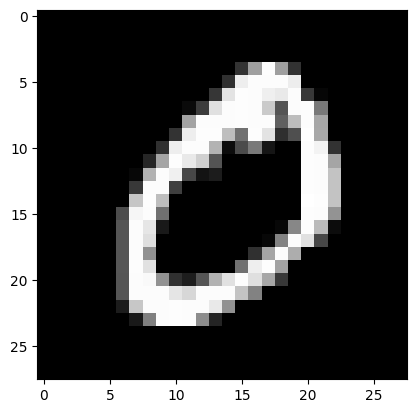

In [30]:
# plot raw pixel data
i = 1 #Index of MNIST Training set
pyplot.imshow(trainX[i], cmap='gray')

### Above We use pyplot to plot the image on a 28x28 grid in grayscale
### Below is 25 images from the Dataset

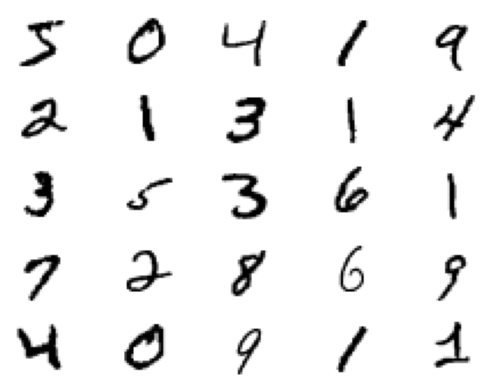

In [31]:
for i in range(25):
 # define subplot
 pyplot.subplot(5, 5, 1 + i)
 # turn off axis
 pyplot.axis('off')
 # plot raw pixel data
 pyplot.imshow(trainX[i], cmap='gray_r')
 #gray_r stands for gray reversed or inverted 
pyplot.show()


Convultion 2D Layers: Made up of multiple filters as defined below often used to detect general shapes/edges
- kernel size: size of the matricie of the filter (Width x Height)

- filters: A matricie of weights, from the original matricie/2D image it takes the dot product of it self and a section of the original image dependent on its size which after iterating over every section of the original image will return the filtered image.

- stride: distance we move the filter at each step

- pooling layers: reduces size of features by taking some kernel size and stride then performing a non-weighted operation and returning a single pixel.

Activation Function Non-Linear (Sigmoid): Returns a value between 0 - 1 which gives us our % prediction if the sample is real or fake

Loss Function (binary cross entropy): Models how well the model is doing - BCE Sums the error between our models function and the training data points with an equation that individually sums negative and positive errors. BCE punishes high errors or low probabilty of a point being either positive or negative by taking the inverse log (values closer to 0 quickly increase)

Dropout: dropping out nodes from the input and hidden layer which creates a new network which helps prevent overfitting

ReLU: Rectified Linear Units, linear in positive dimension but when values are negative it becomes 0, f(x) = max(0,x)
Leaky ReLU: Instead of a flat slope for the negative dimension instead has a small slope

Gradient Descent: Minimizes the loss/error of our function/discriminator by finding a local minimum of some differentiable function in this case the Loss Function/BCE

Stochastic Gradient Descent: When working with large data sets instead of taking the sum of all cost function it instead takes the sum of a random subset.

Adam Version of Stochastic Gradient Descent: Replacement Algo for Stochastic Gradient Descent which improves performance with problems with sparse gradients.




Some confusion I have is the purpose of LeakyReLU when we are using Sigmoid as the activation function.

In [32]:
# define the standalone discriminator model
def define_discriminator(in_shape=(28,28,1)):
 model = Sequential()
 model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=in_shape))
 model.add(LeakyReLU(alpha=0.2))
 model.add(Dropout(0.4))
 model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
 model.add(LeakyReLU(alpha=0.2))
 model.add(Dropout(0.4))
 model.add(Flatten())
 model.add(Dense(1, activation='sigmoid'))
 # compile model
 opt = Adam(learning_rate=0.0002, beta_1=0.5)
 model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
 return model

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 14, 14, 64)        640       
                                                                 
 leaky_re_lu_25 (LeakyReLU)  (None, 14, 14, 64)        0         
                                                                 
 dropout_10 (Dropout)        (None, 14, 14, 64)        0         
                                                                 
 conv2d_16 (Conv2D)          (None, 7, 7, 64)          36928     
                                                                 
 leaky_re_lu_26 (LeakyReLU)  (None, 7, 7, 64)          0         
                                                                 
 dropout_11 (Dropout)        (None, 7, 7, 64)          0         
                                                                 
 flatten_5 (Flatten)         (None, 3136)            

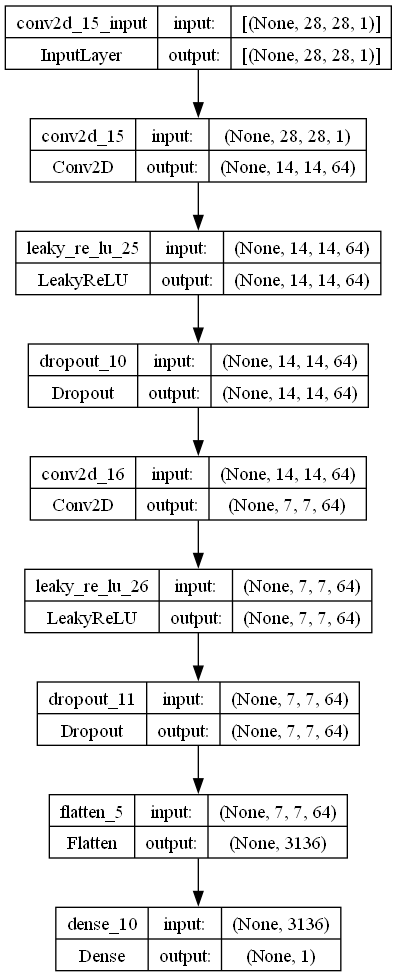

In [33]:
# define model
model = define_discriminator()
# summarize the model
model.summary()
# plot the model
plot_model(model, to_file='discriminator_plot.png', show_shapes=True, show_layer_names=True)

With a Stride of Two our output shape was decreased from 28x28 to 14x14

In [34]:
# load and prepare mnist training images
from numpy import expand_dims


def load_real_samples():
 # load mnist dataset
 (trainX, _), (_, _) = load_data()
 # expand to 3d, e.g. add channels dimension
 X = expand_dims(trainX, axis=-1)
 # convert from unsigned ints to floats
 X = X.astype('float32')
 # scale from [0,255] to [0,1]
 X = X / 255.0
 return X

In [35]:
# select real samples
from numpy.random import randint
from random import sample

from numpy import ones


def generate_real_samples(dataset, n_samples):
 # choose random instances
 ix = randint(0, dataset.shape[0], n_samples) 
 # retrieve selected images
 X = dataset[ix]
 # generate 'real' class labels (1)
 y = ones((n_samples, 1))
 return X, y

In [36]:
# generate n fake samples with class labels
from numpy import zeros
from numpy.random import rand

def generate_fake_samples(n_samples):
 # generate uniform random numbers in [0,1]
 X = rand(28 * 28 * n_samples)
 # reshape into a batch of grayscale images
 X = X.reshape((n_samples, 28, 28, 1))
 # generate 'fake' class labels (0)
 y = zeros((n_samples, 1))
 return X, y

Below we define the train_discriminator function which is currently using real samples from the MNINST dataset and fake samples randomly generated noise.

In [37]:
# train the discriminator model
def train_discriminator(model, dataset, n_iter=100, n_batch=256):
 half_batch = int(n_batch / 2)
 # manually enumerate epochs
 for i in range(n_iter):
 # get randomly selected 'real' samples
    X_real, y_real = generate_real_samples(dataset, half_batch)
 # update discriminator on real samples
    _, real_acc = model.train_on_batch(X_real, y_real)
 # generate 'fake' examples
    X_fake, y_fake = generate_fake_samples(half_batch)
 # update discriminator on fake samples
    _, fake_acc = model.train_on_batch(X_fake, y_fake)
 # summarize performance
 print('>%d real=%.0f%% fake=%.0f%%' % (i+1, real_acc*100, fake_acc*100))

Below we train the model by iterating over the discriminator and its samples by continually changing weights every iteration to minimize the error of the BCE function

In [38]:
# define the discriminator model
model = define_discriminator()
# load image data
dataset = load_real_samples()
# fit the model
train_discriminator(model, dataset)

>100 real=100% fake=100%


## Defining the Generator Model

Latent Space: All possible values of the feature vector in this case a 100 element vector of Gaussian Random Numbers
By drawing points in the latent space randomly and then providing them to the generator model during training the generator model will assign meaning to these latent points, this will in turn assign meaning to the latent space.
At the end of training the Latent Vector Space will represent a compressed output space which our generator can use to turn into plausible MNIST Images

Dense Layer: Has enough nodes to represent a low-resolution version of the output image, if the output image is 28x28 it could be any smaller multiple of 28x28 such as 14x14 or 7x7
28 * 28 = 784 nodes
14 * 14 = 196 nodes
7 * 7 = 49 nodes
The size of the output image scales exponentially with the size of the image so reducing the size by 4 we see a node reduction of 16

In the first hidden layer, the dense layer we need enough for multiple low-resolution versions of output image

In [39]:
# example of defining the generator model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.utils import plot_model
 
# define the standalone generator model
def define_generator(latent_dim):
 model = Sequential()
 # foundation for 7x7 image
 n_nodes = 128 * 7 * 7
 model.add(Dense(n_nodes, input_dim=latent_dim))
 model.add(LeakyReLU(alpha=0.2))
 model.add(Reshape((7, 7, 128)))
 # upsample to 14x14
 model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
 model.add(LeakyReLU(alpha=0.2))
 # upsample to 28x28
 model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
 model.add(LeakyReLU(alpha=0.2))
 model.add(Conv2D(1, (7,7), activation='sigmoid', padding='same'))
 return model

Conv2D Transpose upsamples the resolution of our original 7x7 with a 14x14 as the stride is 2x2 which effectively doubles the size of the feature map, quadrupling the area, we can repeat this again to get back to our 28x28 ouput

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 6272)              633472    
                                                                 
 leaky_re_lu_29 (LeakyReLU)  (None, 6272)              0         
                                                                 
 reshape_5 (Reshape)         (None, 7, 7, 128)         0         
                                                                 
 conv2d_transpose_10 (Conv2  (None, 14, 14, 128)       262272    
 DTranspose)                                                     
                                                                 
 leaky_re_lu_30 (LeakyReLU)  (None, 14, 14, 128)       0         
                                                                 
 conv2d_transpose_11 (Conv2  (None, 28, 28, 128)       262272    
 DTranspose)                                         

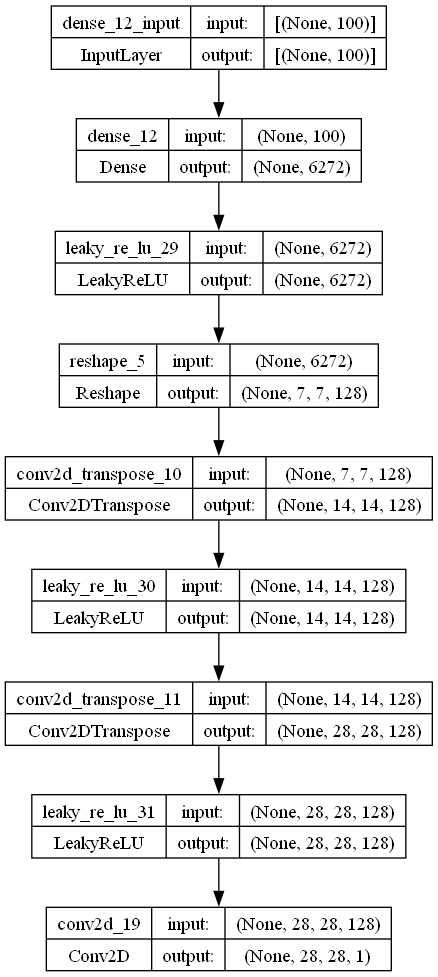

In [40]:
# define the size of the latent space
latent_dim = 100
# define the generator model
model = define_generator(latent_dim)
# summarize the model
model.summary()
# plot the model
plot_model(model, to_file='generator_plot.png', show_shapes=True, show_layer_names=True)

The dense first hidden layer has 7 * 7 * 128 nodes which means we have 128 7x7 feature maps
We can see that the size of the feature maps increase to 128 14x14 and then again to 128 28x28 feature maps after the second conv2d transpose 

In [41]:
from numpy.random import randn
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
 # generate points in the latent space
 x_input = randn(latent_dim * n_samples)
 # reshape into a batch of inputs for the network
 x_input = x_input.reshape(n_samples, latent_dim)
 return x_input

Above we generate random latent points which we will feed to the generator model

In [42]:
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = g_model.predict(x_input)
	# create 'fake' class labels (0)
	y = zeros((n_samples, 1))
	return X, y

Above we generate fake samples by generating random latent points then assigns them with class labels

1/1 [==============================] - 0s 128ms/step


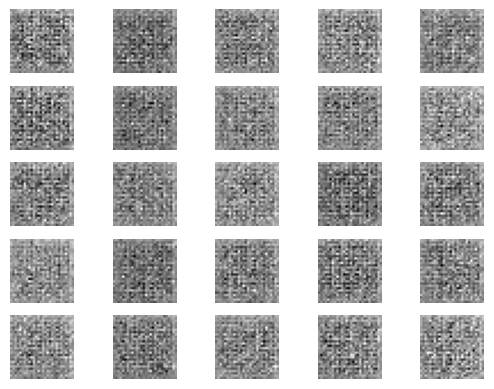

In [43]:
# size of the latent space
latent_dim = 100
# define the discriminator model
model = define_generator(latent_dim)
# generate samples
n_samples = 25
X, _ = generate_fake_samples(model, latent_dim, n_samples)
# plot the generated samples
for i in range(n_samples):
	# define subplot
	pyplot.subplot(5, 5, 1 + i)
	# turn off axis labels
	pyplot.axis('off')
	# plot single image
	pyplot.imshow(X[i, :, :, 0], cmap='gray_r')
# show the figure
pyplot.show()

### Training the Generator Model

The reading of how to train the gan initial remind of me of min-max where the generator is trying to minimize the discriminator ability to detect fake samples and the discriminator is trying to maximize its ability to detect fake samples

From this we can understand why we do not use a loss function for the generator model as the discriminator will act as the generators error/loss and the function for the generator to minimize

In [44]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
 # make weights in the discriminator not trainable
 d_model.trainable = False
 # connect them
 model = Sequential()
 # add generator
 model.add(g_model)
 # add the discriminator
 model.add(d_model)
 # compile model
 opt = Adam(learning_rate=0.0002, beta_1=0.5)
 model.compile(loss='binary_crossentropy', optimizer=opt)
 return model

As the discriminator model was marked as not trainable the only weights that can be changed are those in the generator model

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_18 (Sequential)  (None, 28, 28, 1)         1164289   
                                                                 
 sequential_17 (Sequential)  (None, 1)                 40705     
                                                                 
Total params: 1204994 (4.60 MB)
Trainable params: 1164289 (4.44 MB)
Non-trainable params: 40705 (159.00 KB)
_________________________________________________________________


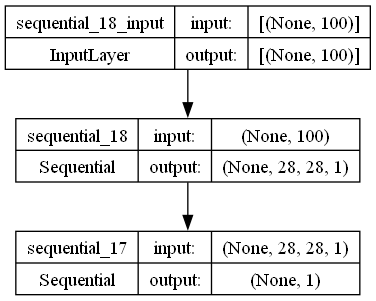

In [45]:
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# summarize gan model
gan_model.summary()
# plot gan model
plot_model(gan_model, to_file='gan_plot.png', show_shapes=True, show_layer_names=True)

In [46]:
# train the composite model
def train_gan(gan_model, latent_dim, n_epochs=100, n_batch=256):
	# manually enumerate epochs
	for i in range(n_epochs):
		# prepare points in latent space as input for the generator
		x_gan = generate_latent_points(latent_dim, n_batch)
		# create inverted labels for the fake samples
		y_gan = ones((n_batch, 1))
		# update the generator via the discriminator's error
		gan_model.train_on_batch(x_gan, y_gan)

In [47]:
# train the generator and discriminator
from numpy import vstack
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=256):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):
			# get randomly selected 'real' samples
			X_real, y_real = generate_real_samples(dataset, half_batch)
			# generate 'fake' examples
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# create training set for the discriminator
			X, y = vstack((X_real, X_fake)), vstack((y_real, y_fake))
			# update discriminator model weights
			d_loss, _ = d_model.train_on_batch(X, y)
			# prepare points in latent space as input for the generator
			X_gan = generate_latent_points(latent_dim, n_batch)
			# create inverted labels for the fake samples
			y_gan = ones((n_batch, 1))
			# update the generator via the discriminator's error
			g_loss = gan_model.train_on_batch(X_gan, y_gan)
			# summarize loss on this batch
			print('>%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, bat_per_epo, d_loss, g_loss))

We only use half the fake batch and half the real batch of real and fake samples to create a single batch to increase performance

We keep track of the loss in each batch where we train the generator to ensure the generator does not start creating bad examples which the discriminator can easily discriminate against

### Evaluating GAN Model Performance 

We need to manually evaluate the quality of the images which means we dont know when to stop training until we can see the generated images


- 1   Periodically evaluate the classification accuracy of the discriminator on real and fake images.
- 2   Periodically generate many images and save them to file for subjective review.
- 3   Periodically save the generator model.


In [48]:

# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
 # prepare real samples
 X_real, y_real = generate_real_samples(dataset, n_samples)
 # evaluate discriminator on real examples
 _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
 # prepare fake examples
 x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
 # evaluate discriminator on fake examples
 _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
 # summarize discriminator performance
 print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))

In [49]:
# create and save a plot of generated images (reversed grayscale)
def save_plot(examples, epoch, n=10):
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
	# save plot to file
	filename = 'generated_plot_e%03d.png' % (epoch+1)
	pyplot.savefig(filename)
	pyplot.close()

In [50]:

# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
	# prepare real samples
	X_real, y_real = generate_real_samples(dataset, n_samples)
	# evaluate discriminator on real examples
	_, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
	# prepare fake examples
	x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
	# evaluate discriminator on fake examples
	_, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
	# summarize discriminator performance
	print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
	# save plot
	save_plot(x_fake, epoch)
	# save the generator model tile file
	filename = 'generator_model_%03d.h5' % (epoch + 1)
	g_model.save(filename)

In [51]:
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples()
# train model
train(g_model, d_model, gan_model, dataset, latent_dim)

4/4 [==============================] - 0s 30ms/step
>1, 1/234, d=0.690, g=0.691
4/4 [==============================] - 0s 29ms/step
>1, 2/234, d=0.689, g=0.715
4/4 [==============================] - 0s 31ms/step
>1, 3/234, d=0.678, g=0.737
4/4 [==============================] - 0s 31ms/step
>1, 4/234, d=0.668, g=0.756
4/4 [==============================] - 0s 32ms/step
>1, 5/234, d=0.663, g=0.776
4/4 [==============================] - 0s 32ms/step
>1, 6/234, d=0.653, g=0.793
4/4 [==============================] - 0s 30ms/step
>1, 7/234, d=0.649, g=0.809
4/4 [==============================] - 0s 31ms/step
>1, 8/234, d=0.640, g=0.832
4/4 [==============================] - 0s 31ms/step
>1, 9/234, d=0.630, g=0.833
4/4 [==============================] - 0s 33ms/step
>1, 10/234, d=0.626, g=0.842
4/4 [==============================] - 0s 31ms/step
>1, 11/234, d=0.626, g=0.836
4/4 [==============================] - 0s 32ms/step
>1, 12/234, d=0.625, g=0.829
4/4 [==============================] 

KeyboardInterrupt: 